!pip install numpy==1.21.6 pandas==1.3.5 matplotlib==3.5.3 seaborn==0.12.2 numba==0.56.4 gdown==4.7.3

# Algoritmo para calcular taxa de retenção
Esse notebook contempla a análise exploratória sobre a retenção de profissionais nas regiões de saúde com base em dados do CNES-PF. O notebook contém o script principal e métodos auxiliares, que ajudam a tratar os dados e criar algumas visualizações.

Observação:
```
Antes de executar o notebook é necessário criar 3 pastas:
- imgs
- csvs
- dados
```

## Carregar bibliotecas

In [1]:
import os
import traceback
import warnings
from operator import attrgetter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gdown

## Configurar bibliotecas

In [2]:
# Remover limite de exibição de linhas e colunas do pandas
pd.set_option('max_rows', 9999)
pd.set_option('max_columns', 9999)

# Evitar notações científicas no pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Evitar warnings sobre perfomance no pandas
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

## Funções auxiliares para tratamento dos dados

In [3]:
def gerar_triangulo_agregado(df_tmp):
    # Converter a coluna competência para o formato ANO-MES (datetime)
    df_tmp['COMPETEN'] = pd.to_datetime(df_tmp['COMPETEN'], format='%Y%m').dt.to_period('M')

    # Criar o grupo no qual o profissional pertence (sua primeira competência)
    df_tmp['coorte'] = df_tmp.groupby('CPF_PROF')['COMPETEN'].transform('min')

    # Contar a quantidade de profissionais distintos por CPF para cada grupo e competência
    df_coorte = df_tmp.groupby(['uf_sigla', 'cod_regsaud', 'coorte', 'COMPETEN']).agg(
        n_prof=('CPF_PROF', 'nunique')).reset_index(drop=False)

    # Eliminar o primeiro grupo
    df_coorte = df_coorte[df_coorte['coorte'] != '2008-01']

    # Calcular a diferença em meses entre a competência e o grupo (primeira competência)
    df_coorte['period_number'] = (df_coorte.COMPETEN - df_coorte.coorte).apply(attrgetter('n'))

    # Realizar pivot da tabela
    coorte_pivot = df_coorte.pivot_table(index=['coorte'], columns='period_number', values='n_prof')

    # Obter o tamanho de cada grupo (coorte)
    coorte_size = coorte_pivot.iloc[:, 0]

    return coorte_pivot, coorte_size


def calcular_percentual_restantes(restantes, coorte_size):
    return restantes.divide(coorte_size.values, axis=0)


def calcular_retencao_ano_regiao(percentual_restantes, regiao_saude):
    aux = percentual_restantes.melt(var_name='periodo', value_name='retention', ignore_index=False).reset_index().rename(
        columns={'index': 'coorte'})
    aux['coorte'] = pd.to_datetime(aux['coorte'])
    aux['a'] = aux.apply(lambda row: row['coorte'] + pd.DateOffset(months=row['periodo']), axis=1)
    aux2 = aux.loc[(aux['a'] <= '2024-01-01') & (aux['periodo'] != 0)].groupby('a').head(5)  # Considera os últimos 5 (diagonal)
    aux2 = aux2.loc[aux['a'] >= '2014-01-01']
    aux2['a'] = aux2['a'].dt.strftime('%Y-%m')
    aux2 = aux2.groupby('a')[['retention']].mean().reset_index().rename(columns={'a': 'ano'})
    aux2['regiao_saude'] = regiao_saude
    return aux2


def pre_processar_dados_retencao(percentual_restantes):
    df = percentual_restantes.reset_index().melt(id_vars='index')
    df['periodo'] = pd.to_datetime(df['index'], format='%Y-%m').dt.to_period('M') + df['variable'].astype(int).apply(
        pd.offsets.MonthEnd)
    df = df.set_index(['variable', 'index']).sort_values(['index', 'variable'])

    return df

## Funções auxiliares para visualização dos dados

In [4]:
def generate_retention_curve(dataframe, ax):
    tmp_df = dataframe.unstack()
    tmp_df.columns = tmp_df.columns.droplevel()
    tmp_df.plot(cmap='tab20', ax=ax)

    ax.legend(ncol=5)
    ax.set_ylim(0, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title('Retenção percentual por período e coorte')
    ax.set_xlabel('períodos (meses)')


def generate_retention_matrix(dataframe, ax, percentual):
    if percentual:
        fmt = '.0%'
        titulo = 'percentual'
    else:
        fmt = 'g'
        titulo = 'absoluta'

    sns.heatmap(dataframe,
                mask=dataframe.isnull(),
                annot=True,
                fmt=fmt,
                annot_kws={"size": 8},
                cmap='RdYlGn',
                ax=ax)

    ax.set(xlabel='períodos (meses)', ylabel='')
    ax.set_title(f'Retenção {titulo} por período e coorte')


def gerar_graficos(restantes, percentual_restantes, titulo, nome_arquivo, save=True):
    # Plotar o gráfico
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])

    # Matriz de Retenção com números absolutos
    generate_retention_matrix(dataframe=restantes.copy(), ax=ax1, percentual=False)

    # Matriz de Retenção com números percentuais
    generate_retention_matrix(dataframe=percentual_restantes.copy(), ax=ax2, percentual=True)

    # Curva de Retenção
    dados_retencao = pre_processar_dados_retencao(percentual_restantes.copy())
    generate_retention_curve(dataframe=dados_retencao.copy(), ax=ax3)

    plt.suptitle(titulo, fontsize=16)
    fig.tight_layout()
    if save:
        plt.savefig(f'./imgs/{nome_arquivo}.png')
        plt.close()
    else:
        plt.show()

## Obter dados

Os dados utilizados são provenientes do Cadastro Nacional de Estabelecimentos de Saúde - Profissionais (CNES-PF). Os arquivos disponibilizados pelo DATASUS na página https://datasus.saude.gov.br/transferencia-de-arquivos/ foram baixados e processados conforme procedimentos descritos a seguir:

- Coletar os dados sobre os profissionais
- Coletar competencia, código do município e CPF do profissional do CNES-PF de forma distinta.
- Ou seja, busca-se encontrar para cada ano e cada profissional, uma linha para cada município onde ele atuou. Entende-se o 'ano' como a competência 01 (janeiro).
- Nesse primeiro momento a análise está limitada apenas aos profissionais médicos e enfermeiros

O procedimento descrito foi realizado por meio da instrução SQL abaixo em infraestrutura própria:

```sql
SELECT DISTINCT
    COMPETEN,
    CODUFMUN,
    CASE
        WHEN pf.CBO LIKE '225%' OR pf.CBO LIKE '2231%' THEN 'Médico'
        WHEN pf.CBO LIKE '2235%' THEN 'Enfermeiro'
        END AS categoria,
    CPF_PROF
FROM Dados.cnes.PF
WHERE
  SUBSTR(COMPETEN, 1, 4) >= 2006
  AND SUBSTR(COMPETEN, 5, 2) = '01'
  AND (
        (pf.CBO LIKE '225%' OR pf.CBO LIKE '2231%') OR -- Medico
        (pf.CBO LIKE '2235%') -- Enfermeiro
    )
```

O exemplo traz consultas para médicos e enfermeiros. No entanto, para nosso artigo estamos focando apenas em médicos.

In [5]:
df = pd.read_parquet('dados/profissionais_meta5.parquet')
df['CODUFMUN'] = df['CODUFMUN'].astype(int)
df.head()

,COMPETEN,CODUFMUN,categoria,CPF_PROF
0,201101,270010,Médico,{{<83>|<84>}<81><82><80><83><84>
1,201101,270030,Enfermeiro,{<80><80>~|{<81><82>{}
2,201101,270030,Técnicos e auxiliares de enfermagem,~{<84><83><82>|<81><84>
3,201101,270030,Técnicos e auxiliares de enfermagem,{<80><82><80><81><83><81>}~<84>
4,201101,270030,Técnicos e auxiliares de enfermagem,{}}<80>|<81><84>}{|


Os dados sobre os municípios também foram coletados do DATASUS (https://datasus.saude.gov.br/transferencia-de-arquivos/), por meio do arquivo Base Territorial e tratado em infraestrutura própria. A consulta SQL mostra a junção das tabelas:

```sql
SELECT DISTINCT
    uf.DS_NOME as uf,
    uf.DS_sigla as uf_sigla,
    rs.CO_REGSAUD as cod_regsaud,
    rs.DS_NOME as regiao_saude,
    mun.CO_MUNICIP as cod_municipio,
    mun.CO_MUNICDV as cod_municipiodv,
    mun.DS_NOME as municipio
FROM "Dados.territorial"."tb_municip.parquet" mun
INNER JOIN "Dados.territorial"."tb_uf.parquet" uf on uf.CO_UF = mun.CO_UF
INNER JOIN "Dados.territorial"."rl_municip_regsaud.parquet" rsm on rsm.CO_MUNICIP = mun.CO_MUNICIP
INNER JOIN "Dados.territorial"."tb_regsaud.parquet" rs on rs.CO_REGSAUD = rsm.CO_REGSAUD
INNER JOIN "Dados.territorial"."rl_municip_macsaud.parquet" mrsm on mrsm.CO_MUNICIP = mun.CO_MUNICIP
INNER JOIN "Dados.territorial"."tb_regiao.parquet" mrs on mrs.CO_REGIAO = uf.CO_REGIAO
INNER JOIN "Dados.territorial"."rl_municip_macsaud.parquet" rlmac on rlmac.CO_MUNICIP = mun.CO_MUNICIP
INNER JOIN "Dados.territorial"."tb_macsaud.parquet" mac on CAST(rlmac.CO_MACSAUD AS VARCHAR) = mac.CO_MACSAUD
INNER JOIN "Dados.territorial"."lat_long.parquet" ll on CAST(mun.CO_MUNICIP AS VARCHAR) = ll.municipio
WHERE
    mun.CO_STATUS = 'ATIVO' AND
    uf.CO_STATUS = 'ATIVO' AND
    rs.CO_STATUS = 'ATIVO' AND
    mrs.CO_STATUS = 'ATIVO' AND
    mac.CO_STATUS = 'ATIVO'
```

In [6]:
url = 'https://drive.google.com/uc?id=1pr-ZUVU5LaCdvb9VsnUqxFmIype1Aqll'
output = 'dados/municipios.parquet'

gdown.download(url, output, quiet=False)
geo = pd.read_parquet(output)
geo['cod_regsaud'] = geo['cod_regsaud'].astype(str)
geo.head()

Downloading...
From: https://drive.google.com/uc?id=1pr-ZUVU5LaCdvb9VsnUqxFmIype1Aqll
To: C:\Projetos Git\UFG\artigo-retencao\dados\municipios.parquet
100%|██████████| 159k/159k [00:00<00:00, 965kB/s]


,uf,uf_sigla,cod_regsaud,regiao_saude,cod_municipiodv,cod_municipio,municipio
0,Rondônia,RO,11001,Vale do Jamari,1100452,110045,Buritis
1,Rondônia,RO,11003,Central,1100114,110011,Jaru
2,Rondônia,RO,11003,Central,1100254,110025,Presidente Médici
3,Rondônia,RO,11004,Madeira-Mamoré,1100205,110020,Porto Velho
4,Rondônia,RO,11004,Madeira-Mamoré,1100809,110080,Candeias do Jamari


In [7]:
# Realizar o join dos dados do CNES com tabela de municipios
df = df.merge(geo, left_on=['CODUFMUN'], right_on=['cod_municipio'])
df.head()

,COMPETEN,CODUFMUN,categoria,CPF_PROF,uf,uf_sigla,cod_regsaud,regiao_saude,cod_municipiodv,cod_municipio,municipio
0,201101,270010,Médico,{{<83>|<84>}<81><82><80><83><84>,Alagoas,AL,27010,10ª Região de Saúde,2700102,270010,Água Branca
1,201201,270010,Enfermeiro,{<80><83><81><83><83>}~<82>,Alagoas,AL,27010,10ª Região de Saúde,2700102,270010,Água Branca
2,201201,270010,Técnicos e auxiliares de enfermagem,{}}<80><84>~<80><83><83><84>,Alagoas,AL,27010,10ª Região de Saúde,2700102,270010,Água Branca
3,201201,270010,Técnicos e auxiliares de enfermagem,{~<83><83><80><82><84><80>},Alagoas,AL,27010,10ª Região de Saúde,2700102,270010,Água Branca
4,201201,270010,Técnicos e auxiliares de enfermagem,<80>}|}<84><82>{<84>|,Alagoas,AL,27010,10ª Região de Saúde,2700102,270010,Água Branca


## Processo passo a passo
A seguir o algoritmo da análise será executado passo a passo para uma região de saúde específica e uma categoria profissional como forma de exemplificação.

In [8]:
regiao_saude = '11001'
categoria = 'Médico'
nome_regiao = 'Vale do Jamari'
uf_regiao = 'RO'

In [9]:
df_exemplo = df.loc[(df['categoria'] == categoria) & (df['cod_regsaud'] == regiao_saude)].copy()
df_exemplo.head()

,COMPETEN,CODUFMUN,categoria,CPF_PROF,uf,uf_sigla,cod_regsaud,regiao_saude,cod_municipiodv,cod_municipio,municipio
7500381,202101,110002,Médico,<82><80><83>}<81><81>|}<81><83>,Rondônia,RO,11001,Vale do Jamari,1100023,110002,Ariquemes
7500389,202101,110002,Médico,<83><81><81>|}<81><80>}<83><82>,Rondônia,RO,11001,Vale do Jamari,1100023,110002,Ariquemes
7500391,202101,110002,Médico,{{}<83><82>{<81>}}<81>{,Rondônia,RO,11001,Vale do Jamari,1100023,110002,Ariquemes
7500396,202101,110002,Médico,<84>~<84><81>~<83>~|}{{,Rondônia,RO,11001,Vale do Jamari,1100023,110002,Ariquemes
7500399,202101,110002,Médico,~}<83>{<81><81>|}|<83><82>,Rondônia,RO,11001,Vale do Jamari,1100023,110002,Ariquemes


### Gerar triângulo
A partir do método gerar_triangulo_agregado é possível obter o triângulo da retenção dos profissionais. O triângulo é uma matriz que mostra a quantidade de profissionais que permaneceram a cada intervalo de 12 meses. O período 0 representa o início do grupo, ou seja, a quantidade de profissionais que iniciaram no grupo, esses valores são separados na variável `exemplo_sizes` para uso futuro.

In [10]:
exemplo_pivot, exemplo_sizes = gerar_triangulo_agregado(df_exemplo.copy())
exemplo_pivot

period_number,0,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180
coorte,,,,,,,,,,,,,,,,
2009-01,35.00,30.00,26.00,19.00,17.00,17.00,17.00,14.00,14.00,11.00,12.00,9.00,9.00,8.00,8.00,8.00
2010-01,24.00,15.00,11.00,12.00,12.00,11.00,8.00,9.00,10.00,8.00,8.00,8.00,8.00,8.00,8.00,NaN
2011-01,31.00,22.00,20.00,17.00,15.00,12.00,11.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,NaN,NaN
2012-01,23.00,19.00,14.00,14.00,13.00,11.00,11.00,8.00,8.00,10.00,9.00,8.00,8.00,NaN,NaN,NaN
2013-01,28.00,17.00,15.00,14.00,15.00,15.00,14.00,13.00,13.00,13.00,12.00,12.00,NaN,NaN,NaN,NaN
2014-01,28.00,17.00,17.00,11.00,10.00,8.00,6.00,7.00,6.00,7.00,8.00,NaN,NaN,NaN,NaN,NaN
2015-01,54.00,40.00,37.00,26.00,17.00,11.00,11.00,11.00,10.00,11.00,NaN,NaN,NaN,NaN,NaN,NaN
2016-01,31.00,22.00,16.00,11.00,11.00,8.00,8.00,11.00,8.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,57.00,43.00,23.00,23.00,22.00,21.00,20.00,20.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Tratar os dados do triângulo
Os nomes dos índices são descartados e seu tipo é alterado para string no formato ANO-DIA.

In [11]:
exemplo_pivot.index.set_names([None], inplace=True)
exemplo_pivot.columns.name = None
exemplo_pivot.index = exemplo_pivot.index.strftime('%Y-%m')

### Calcular percentual de retenção
Os valores do triângulo são divididos pelo tamanho do grupo para obter o percentual de retenção.

In [12]:
percentual_restantes = calcular_percentual_restantes(exemplo_pivot, exemplo_pivot[0])
percentual_restantes

,0,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180
2009-01,1.00,0.86,0.74,0.54,0.49,0.49,0.49,0.40,0.40,0.31,0.34,0.26,0.26,0.23,0.23,0.23
2010-01,1.00,0.62,0.46,0.50,0.50,0.46,0.33,0.38,0.42,0.33,0.33,0.33,0.33,0.33,0.33,NaN
2011-01,1.00,0.71,0.65,0.55,0.48,0.39,0.35,0.32,0.32,0.32,0.32,0.32,0.32,0.32,NaN,NaN
2012-01,1.00,0.83,0.61,0.61,0.57,0.48,0.48,0.35,0.35,0.43,0.39,0.35,0.35,NaN,NaN,NaN
2013-01,1.00,0.61,0.54,0.50,0.54,0.54,0.50,0.46,0.46,0.46,0.43,0.43,NaN,NaN,NaN,NaN
2014-01,1.00,0.61,0.61,0.39,0.36,0.29,0.21,0.25,0.21,0.25,0.29,NaN,NaN,NaN,NaN,NaN
2015-01,1.00,0.74,0.69,0.48,0.31,0.20,0.20,0.20,0.19,0.20,NaN,NaN,NaN,NaN,NaN,NaN
2016-01,1.00,0.71,0.52,0.35,0.35,0.26,0.26,0.35,0.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.00,0.75,0.40,0.40,0.39,0.37,0.35,0.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.00,0.54,0.45,0.41,0.36,0.34,0.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calcular retenção anual (últimos 5 anos) por região de saúde

In [13]:
retencao_anual = calcular_retencao_ano_regiao(percentual_restantes.copy(), regiao_saude)
retencao_anual

,ano,retention,regiao_saude
0,2014-01,0.55,11001
1,2015-01,0.54,11001
2,2016-01,0.56,11001
3,2017-01,0.56,11001
4,2018-01,0.53,11001
5,2019-01,0.38,11001
6,2020-01,0.43,11001
7,2021-01,0.50,11001
8,2022-01,0.52,11001
9,2023-01,0.50,11001


### Calcular retenção geral (média de todo o triangulo)

In [14]:
pd.DataFrame({'regiao_saude': [regiao_saude], 'retencao_geral': [exemplo_pivot.divide(exemplo_sizes[0], axis = 0).unstack().mean()]})

,regiao_saude,retencao_geral
0,11001,0.57


### Gerar gráficos

O primeiro gráfico mostra o triângulo em números absolutos, o segundo gráfico mostra o triângulo em números percentuais e o terceiro gráfico mostra a curva de retenção (uma visualização alternativa ao segundo triângulo).

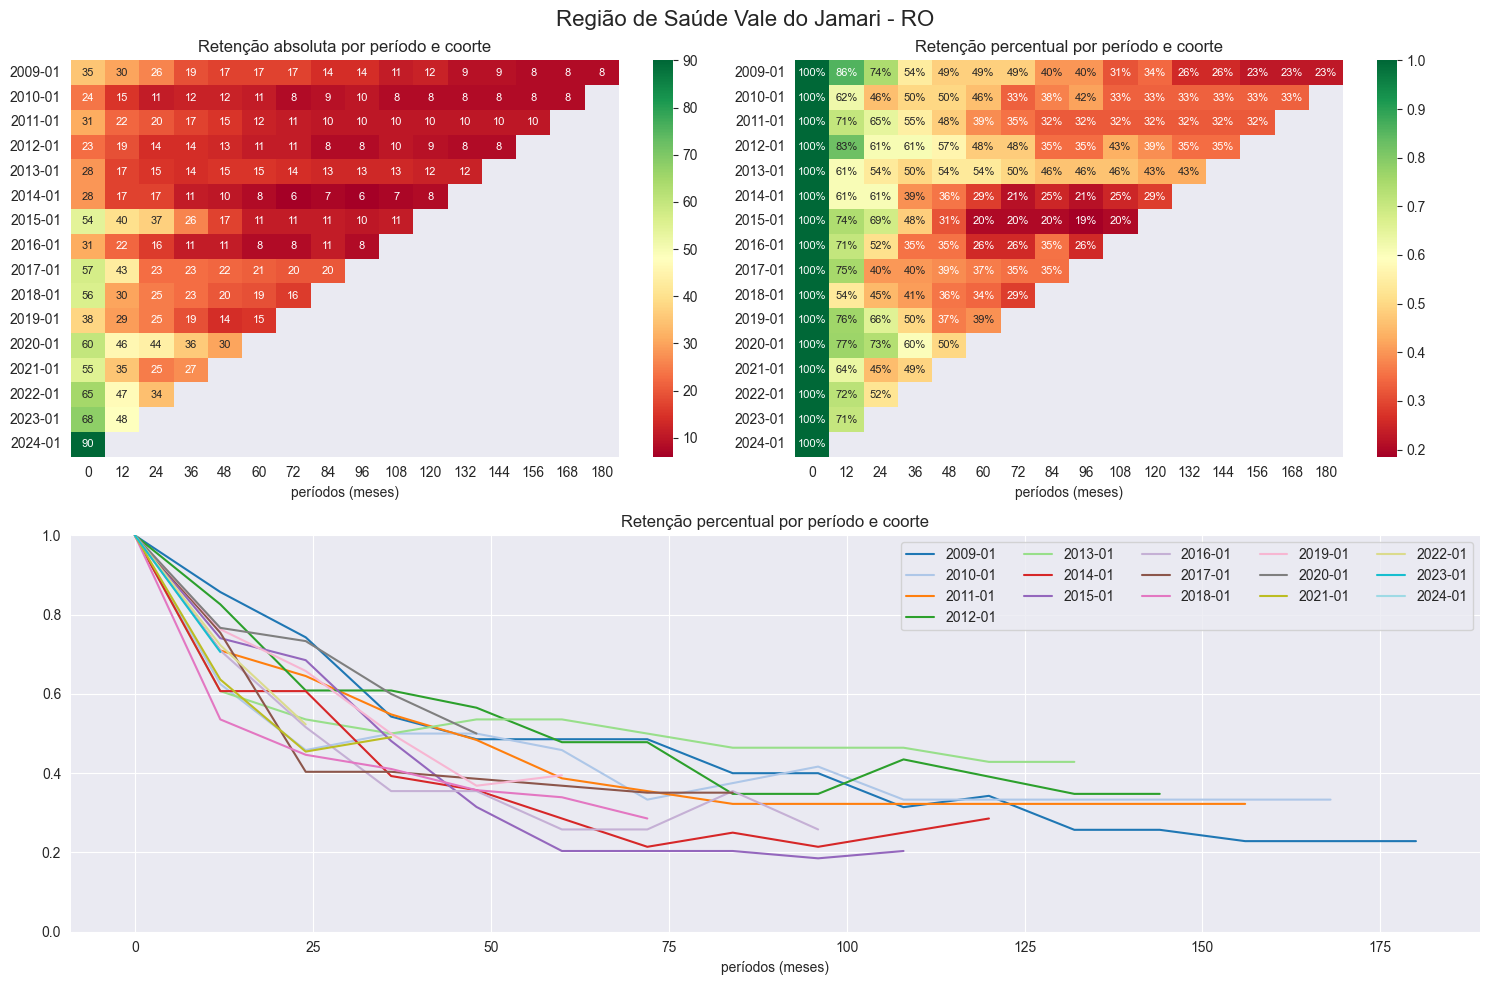

In [15]:
gerar_graficos(exemplo_pivot.copy(), percentual_restantes.copy(), f'Região de Saúde {nome_regiao} - {uf_regiao}', f'{categoria}{regiao_saude}', False)

## Processar os dados e criar os gráficos e arquivos CSV de retenção por região de saúde
Agora o processamento é automatizado para todas as regiões de saúde do Brasil, seguindo os mesmos passos já detalhados anteriormente.

In [17]:
# Realizar processamento para cada categoria profissional
for categoria in df['categoria'].unique():
    try:
        os.makedirs(f'./imgs/{categoria}')
    except FileExistsError:
        pass

    df_categoria = df.loc[df['categoria'] == categoria].copy()

    # Criar listas para salvar dados a serem exportados
    triangulos = []
    retencao_ano = []
    retencao_geral = []

    # Realizar o processamento separado para cada região de saúde
    i=0
    for regiao_saude in df['cod_regsaud'].unique():
        try:
            print(f'Processando {categoria} | {regiao_saude} - {i+1}/{len(df["cod_regsaud"].unique())}')
            df_categoria_regiao = df_categoria.loc[df_categoria['cod_regsaud'] == regiao_saude].copy()

            # Agregar os dados por coortes
            coorte_pivot, coorte_sizes = gerar_triangulo_agregado(df_categoria_regiao.copy())

            for fill_na in list(range(0, 181, 12)):
                if fill_na not in coorte_pivot.columns:
                    coorte_pivot[fill_na] = np.nan


            # Calcular profissionais restantes em cada período do coorte
            coorte_pivot.index.set_names([None], inplace=True)
            coorte_pivot.columns.name = None
            coorte_pivot.index = coorte_pivot.index.strftime('%Y-%m')

            # Realizar a divisão de cada célula da tabela pivotada pelo tamanho do grupo para deixar em percentual
            percentual_restantes = calcular_percentual_restantes(coorte_pivot, coorte_pivot[0])

            # Calcular retenção anual (últimos 5 anos) por região de saúde
            retencao_anual = calcular_retencao_ano_regiao(percentual_restantes.copy(), regiao_saude)
            retencao_ano.append(retencao_anual)

            # Calcular retenção geral (média de todo o triangulo)
            retencao_geral.append(pd.DataFrame({'regiao_saude': [regiao_saude], 'retencao_geral': [coorte_pivot.divide(coorte_sizes[0], axis = 0).unstack().mean()]}))

            # Salvar dados do triangulo para exportar em csv
            coorte_pivot['cod_regsaud'] = regiao_saude
            triangulos.append(coorte_pivot.copy())
            coorte_pivot.drop(['cod_regsaud'], axis=1, inplace=True)

            # Gerar gráficos
            nome_regiao = df_categoria_regiao["regiao_saude"].values[0]
            uf_regiao = df_categoria_regiao["uf_sigla"].values[0]
            gerar_graficos(coorte_pivot.copy(), percentual_restantes.copy(), f'Região de Saúde {nome_regiao} - {uf_regiao}', f'{categoria}/{regiao_saude}')
            i+=1
        except Exception as e:
            print(f'Erro na região de saúde {regiao_saude}: {e}')
            print(traceback.format_exc())
            continue


    # Exportar dados em CSV
    pd.concat(triangulos).to_csv(f'csvs/{categoria}_triangulos.csv', sep=';')
    pd.concat(retencao_ano).to_csv(f'csvs/{categoria}_retencao_ano.csv', sep=';')
    pd.concat(retencao_geral).to_csv(f'csvs/{categoria}_retencao_geral.csv', sep=';')

Processando Médico | 27010 - 1/450
Processando Médico | 27007 - 2/450
Processando Médico | 27004 - 3/450
Processando Médico | 27001 - 4/450
Processando Médico | 27005 - 5/450
Processando Médico | 27003 - 6/450
Processando Médico | 27009 - 7/450
Processando Médico | 27006 - 8/450
Processando Médico | 27008 - 9/450
Processando Médico | 27002 - 10/450
Processando Médico | 13008 - 11/450
Processando Médico | 13009 - 12/450
Processando Médico | 13002 - 13/450
Processando Médico | 13003 - 14/450
Processando Médico | 13001 - 15/450
Processando Médico | 13005 - 16/450
Processando Médico | 13007 - 17/450
Processando Médico | 13004 - 18/450
Processando Médico | 13006 - 19/450
Processando Médico | 16001 - 20/450
Processando Médico | 16002 - 21/450
Processando Médico | 16003 - 22/450
Processando Médico | 29020 - 23/450
Processando Médico | 29004 - 24/450
Processando Médico | 29001 - 25/450
Processando Médico | 29019 - 26/450
Processando Médico | 29026 - 27/450
Processando Médico | 29011 - 28/450
P

In [18]:
1+1

2